# Discover your Reachy robot

This notebook will show you how to start with your Reachy robot and how to start working with it. You will see how you can:

* start your Robot
* read values from the sensor
* send motor commands
* start higher level behaviors

*Note that the code of this notebook will actually run in the raspberry pi of the robot and not on your computer. If you are not familiar with the [jupyter notebook](http://jupyter.org/) interface, you can refer to their excellent documentation: http://jupyter.org/documentation.html*

## Start your Reachy robot

The first step before working with your reachy robot is to setup the connection with the hardware (the motors and sensors). To do that you simply have to run the two following line of codes:

In [1]:
# Import the reachy library.
from reachy import Reachy

# Setup the communication used to handle the communication with the hardware.
reachy = Reachy()

If everything goes well you should now be connected to your robot. The values are automatically synced between the hardware on your Robot object.

*Beware that you cannot have two instances connected to the same robot at the same time!*

## Read sensor values

You can simply read values from the motors/sensors. For instance, if you want to display the current position of the shoulder pitch motor you can use the following code:

In [2]:
print(reachy.shoulder_pitch.present_position)

-1.74


Note that you can directly access motor by their name:

In [3]:
print(reachy.arm_yaw)

<DxlMotor name=arm_yaw id=12 pos=-6.55>


You can also retrieve all motors using:

In [4]:
print(reachy.motors)

[<DxlMotor name=shoulder_pitch id=10 pos=-1.82>, <DxlMotor name=shoulder_roll id=11 pos=3.19>, <DxlMotor name=arm_yaw id=12 pos=-6.55>, <DxlMotor name=elbow_pitch id=13 pos=-0.04>, <DxlMotor name=forearm_yaw id=14 pos=-1.03>, <DxlMotor name=wrist_pitch id=15 pos=52.05>, <DxlMotor name=wrist_roll id=16 pos=2.49>]


This can be used to display the current position of all motors:

In [5]:
for motor in reachy.motors:
    print('The motor "%s" is currently in position: %f' % (motor.name, motor.present_position))

The motor "shoulder_pitch" is currently in position: -1.820000
The motor "shoulder_roll" is currently in position: 3.100000
The motor "arm_yaw" is currently in position: -6.550000
The motor "elbow_pitch" is currently in position: -0.040000
The motor "forearm_yaw" is currently in position: -1.030000
The motor "wrist_pitch" is currently in position: 52.640000
The motor "wrist_roll" is currently in position: 2.490000


You can similarly access other sensing values like:

* present_position
* present_speed
* present_load
* present_temperature

For instance:

In [6]:
print(reachy.elbow_pitch.present_speed)

0.0


## Send motor commands

Before trying to move Reachy motors you should make sure that they are in stiff mode. Dynamixel motors have two modes:

* compliant: where you can freely move the motors by hand (for instance for demonstration, see below)
* stiff: where the motor is hard and can be controlled

So here we want to change them to stiff mode (actually we will set them to not compliant):

In [7]:
for motor in reachy.motors:
    motor.compliant = False

You can send motor commands in a similar way. For instance to change the position of the shoulder_roll motor:

In [8]:
reachy.shoulder_roll.goal_position = 30 # in degrees

*Be careful that the "actual" value is named present_position while the asked one is goal_position*. 

Depending on how you control the motors, the movements can be shaky. A good way to prevent this is to set the maximum speed for a motor:

In [9]:
reachy.shoulder_roll.moving_speed = 50 # in rpm

Note that in dynamixel motors the maximum speed is named "moving_speed".

In [10]:
reachy.shoulder_roll.goal_position = 0

The movement should now be smoother.

You can also use the *torque_limit* register (expressed in %) to prevent the motor from forcing too much:

In [11]:
reachy.shoulder_pitch.torque_limit = 75

## Higher level behaviors

### Apply sinus and plot the trajectories

The next example shows you how to apply a sinusoid on a motor:

In [12]:
from time import time, sleep
from numpy import sin, pi

duration = 10 # in sec.
freq = 0.5 # in Hz
amp = 30 # in degrees

update_frequency = 50 # in Hz - meaning how fast we will send motor commands

start = time()
while time() - start < duration:
    target_pos = amp * sin(2 * pi * freq * time())
    reachy.arm_yaw.goal_position = target_pos
    
    sleep(1.0 / update_frequency)

You can modify the example to also record its real and target position during the motion:

In [13]:
from time import time, sleep
from numpy import sin, pi

duration = 10 # in sec.
freq = 0.5 # in Hz
amp = 30 # in degrees

update_frequency = 50 # in Hz - meaning how fast we will send motor commands

start = time()

real_pos = []
goal_pos = []

while time() - start < duration:
    target_pos = amp * sin(2 * pi * freq * time())
    reachy.arm_yaw.goal_position = target_pos
    
    real_pos.append(reachy.arm_yaw.present_position)
    goal_pos.append(reachy.arm_yaw.goal_position)
    
    sleep(1.0 / update_frequency)

And then plot it using a dedicated library:

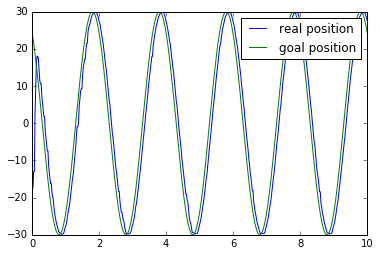

In [14]:
%matplotlib inline

from matplotlib import pylab as plt
from numpy import linspace

t = linspace(0, 10, len(real_pos))

plt.plot(t, real_pos)
plt.plot(t, goal_pos)

plt.legend(('real position', 'goal position'))

You can thus see the lag between the motor command and its reach.

### Using physical demonstrations

As stated above, dynamixel motors have a compliant mode where they can be freely moved. You can change them to compliant mode using:

In [15]:
for motor in reachy.motors:
    motor.compliant = True

You should now be able to freely move the robot. This can be useful for recording demonstrations. This means you can still record the *present_position* of the motor while they are in compliant mode and then apply these trajectories again when they are in stiff mode to reproduce the demo.

Reachy provides high level commands to do that. You can start a new demonstration by using:

In [16]:
reachy.record.start()

And then all movements applied to the motors are recorded. When you want to stop the recording you can do:

In [17]:
reachy.record.stop()

The motors turn stiff again so you can reproduce the demonstration using:

In [18]:
reachy.play.start()

*Be careful that playing recorded movements will change the maximum_speed of your motors!*